## CLASSIFICATION: UNCLASSIFIED

## Word embedding and 1D Convolution Network Example

### The techniques

We illustrate two deep learning techniques over text in this short notebook, namely:

* word embedding to reduce dimensionality, and
* 1D convolutional networks for the classification model.

Thw 2D convolutional network models is very successful for object recognition, as
it is able to preserve the spatial structure of the problem. They typically use fewer parameters
than fully connected nets, and are designed to be invariant to object position or distortion.
The same principle can be used on text data using 1D convolutional neural nets.

There are 3 building blocks (layer types) in CNNs:

* convolutional: which consist of filters over square patches (2D) or strings (1D), and feature maps, which is the output of the filter drawn across the entire previous layer;
* pooling: which down-sample the previous layer feature map, and
* fully connected: as in feed-forward neural nets.

### The Data

We look at movie review from IMDb which consists of 50,000 reviews categorized as positive or negative. The 5000 most frequent words (from the training set) are used; other words are mapped to '.' Most review being under 500 words, reviews are truncated (or padded) to this length. 

import thweWord embedding (down to 32 dimensions) is used as a first step for the CNN.

In [23]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.datasets import imdb
from keras.preprocessing import sequence

import pickle
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

## known bug with Dropout() layer in Keras when using tensorflow, do this:
#keras.backend.set_learning_phase(1)
#import keras.backend.tensorflow_backend as K ## to set CPU or GPU .. eventually


### Read data


In [24]:
## Use most frequent n_words
## 0 is used for padding, 1 for start of text, 2 for out-of-vocab words
import get_data
get_data.get_file("imdb_full.pkl", "../data/")
with open('../data/imdb_full.pkl','rb') as infile:
    X = pickle.load(infile)
base = 2
n_words = 5000 
%run ../data/imdb.py
(X_train, Y_train) , (X_test,Y_test)  = load_data(data=X,num_words=n_words, oov_char=base, index_from=base)

### Word frequencies

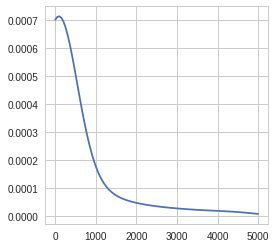

In [25]:
## distribution of word frequencies
plt.rcParams['figure.figsize'] = (4,4)
x = [v for x in X_train for v in x]
sb.set_style('whitegrid')
sb.kdeplot(np.array(x), bw=.5)


### Paragraph length distribution

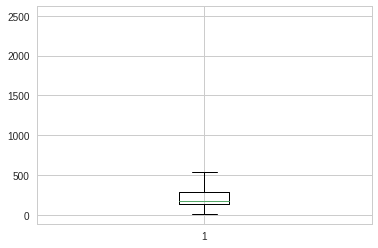

In [26]:
## boxplot shows that truncating around 500 is fine
## padding will be used for shorter texts
plt.rcParams['figure.figsize'] = (6,4)
review_len = [len(x) for x in X_train]
plt.boxplot(review_len)
seq_len = 500  ## we will truncate/pad to this length
plt.show()

### Build dictionaries

Build structures to go from index to word and vice-versa.


In [27]:
## dictionaries: words <--> indices
with open('../data/imdb_word_index.json','rb') as infile:
    word_to_index = json.load(infile)
index_to_word = {v:k for k,v in word_to_index.items() }
index_to_word[0] = '.' ## oov words
## utility function to view a paragraph
def sentence(x):    
    return(' '.join([index_to_word[i-base] for i in x[1:] if i>=base]))
    #return(' '.join([index_to_word[i-base] for i in x[1:] if i>=base]))

In [28]:
## What are the top word? ('.' represents all 'other' words)
[index_to_word[i] for i in range(20)]

['.',
 'the',
 'and',
 'a',
 'of',
 'to',
 'is',
 'br',
 'in',
 'it',
 'i',
 'this',
 'that',
 'was',
 'as',
 'for',
 'with',
 'movie',
 'but',
 'film']

In [29]:
index_to_word

{34701: 'fawn',
 52006: 'tsukino',
 52007: 'nunnery',
 16816: 'sonja',
 63951: 'vani',
 1408: 'woods',
 16115: 'spiders',
 2345: 'hanging',
 2289: 'woody',
 52008: 'trawling',
 52009: "hold's",
 11307: 'comically',
 40830: 'localized',
 30568: 'disobeying',
 52010: "'royale",
 40831: "harpo's",
 52011: 'canet',
 19313: 'aileen',
 52012: 'acurately',
 52013: "diplomat's",
 25242: 'rickman',
 6746: 'arranged',
 52014: 'rumbustious',
 52015: 'familiarness',
 52016: "spider'",
 68804: 'hahahah',
 52017: "wood'",
 40833: 'transvestism',
 34702: "hangin'",
 2338: 'bringing',
 40834: 'seamier',
 34703: 'wooded',
 52018: 'bravora',
 16817: 'grueling',
 1636: 'wooden',
 16818: 'wednesday',
 52019: "'prix",
 34704: 'altagracia',
 52020: 'circuitry',
 11585: 'crotch',
 57766: 'busybody',
 52021: "tart'n'tangy",
 14129: 'burgade',
 52023: 'thrace',
 11038: "tom's",
 52025: 'snuggles',
 29114: 'francesco',
 52027: 'complainers',
 52125: 'templarios',
 40835: '272',
 52028: '273',
 52130: 'zaniacs',

In [30]:
index_to_word[0]

'.'

In [31]:
## Pad/truncate reviews
X_train = sequence.pad_sequences(X_train, maxlen=seq_len)
X_test = sequence.pad_sequences(X_test, maxlen=seq_len)

## Feed forward net

We build a simple FFNN for comparison. This simple model yields 87.8% accuracy on the test set. 

In [32]:
## model
ffnn = Sequential()
ffnn.add(Embedding(n_words, 32, input_length=seq_len))
ffnn.add(Flatten())
ffnn.add(Dense(250, activation='relu'))
ffnn.add(Dropout(0.25))
ffnn.add(Dense(1, activation='sigmoid'))
ffnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
ffnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
flatten_3 (Flatten)          (None, 16000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 250)               4000250   
_________________________________________________________________
dropout_3 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 251       
Total params: 4,160,501.0
Trainable params: 4,160,501.0
Non-trainable params: 0.0
_________________________________________________________________


In [33]:
ffnn.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=2, batch_size=128, verbose=0)
sc = ffnn.evaluate(X_test, Y_test, verbose=0)
print('accuracy = ',sc[1])


accuracy =  0.87836


## 1D Convolutional Network with Word Embedding

The first layer learns an embedding of words, which can be seen as extremely sparse
5000-dim. vectors, into 32-dimensional space. This embedding is part of the CNN 
itself and is learned at the same time as the rest of the model.

It is followed by the usual Conv1D and MaxPooling layers already described.
The data must then be flatten (from size 250x32 to 8000) before applying a dense
layer with dropout. The final (dense) layer outputs a single neuron with the sigmoid
activation function, which will the the learned prediction of the sentiment of the
review (0=negative, 1=positive).


In [34]:
## model - 1D CNN with 32d word embedding
model = Sequential()
model.add(Embedding(n_words, 32, input_length=seq_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 500, 32)           3104      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 250, 32)           0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 250)               2000250   
_________________________________________________________________
dropout_4 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 251       
Total para

### Fit and test the model

We fit the model (2 epochs); accuracy on the test data is about 88.5%

In [40]:
## fit and test
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=2, batch_size=128, verbose=0)
sc = model.evaluate(X_test, Y_test, verbose=0)
print('accuracy = ',sc[1])


accuracy =  0.86764


## Examples of false positive/negative reviews

We look at examples where:

* the model gives a high score, but the label is 0 (false positive)
* the model gives a low score, but the label is 1 (false negative)

Such exploration can be useful to detect flaws in the model ... or in the data itself, for example, mis-labelling.


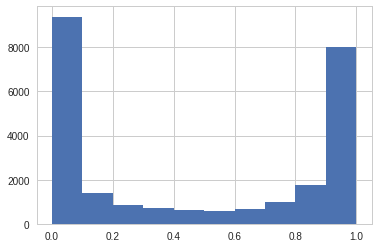

In [36]:
## get the prediction scores - most are close to either 0 or 1
pred = model.predict(X_test)
plt.hist(pred)
plt.show()

In [37]:
## False Negative
fn = [x for x in range(len(Y_test)) if Y_test[x] == 1 and pred[x] < .001]
sentence(X_test[fn[1]])


"black . can't be there's a documentary dark end of the street about s f street . and b t abuse not bad quite heavy in wasted there's this stuff that looks like . but should be something else no big deal black . can't be there's a documentary dark end of the street about s f street . and b t abuse not bad quite heavy in wasted there's this stuff that looks like . but should be something else no big deal black . can't be there's a documentary dark end of the street about s f street . and b t abuse not bad quite heavy in wasted there's this stuff that looks like . but should be something else no big deal"

In [38]:
## False Positive - this one seems like mis-labelling
fp = [x for x in range(len(Y_test)) if Y_test[x] == 0 and pred[x] > .999]
sentence(X_test[fp[0]])


"i went to see this 3 nights ago here in . ireland it was the world . of it in the tiny cinema in the arts . as part of the . film festival br br i found strange . to be an excellent movie it is a bit rough around the . but for a low budget movie that is to be expected in general the acting particularly from the main lead . is wonderful the cinematography and direction excellent and the script . entertaining and thought provoking with some nice set ups and witty dialogue br br the ending was a bit sudden with no conclusion given to characters and events once the finale came to its gripping end but perhaps that's what the filmmakers were going for it certainly did make the movie more unsettling i did like the fact that the main character never came to terms with his mother on screen it leaves you wondering whether or not he ever will as in real life sometimes these things are never . this was a good choice to leave it . rather than . . it up br br . and suspenseful throughout strange . 